In [1]:
import pandas as pd
import numpy as np
import scipy as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore') 

# Time Series Generation

In [101]:
T = 2000
y0 = 100
y1 = 100
y = [y0]
y.append(y1)
d = 0.025
phi = 0.6
theta = -0.4

def generate_time_series(T, y, d, phi, theta):
    np.random.seed(20135083)

    prev_noise = np.random.standard_normal(1)

    for i in range(1, T-1):
        # generate noise
        noise = np.random.standard_normal(1)
        # calculate previous delta
        prev_delta_y = y[-1] - y[-2]

        # update
        delta_y = d + phi*(prev_delta_y - d) + noise + theta*prev_noise

        # increment price
        y.append(y[-1] + delta_y[0])

        # store current noise as previous noise
        prev_noise = noise

        price = np.asarray(y)
        
    return price
    
price = generate_time_series(T, y.copy(), d, phi, theta)

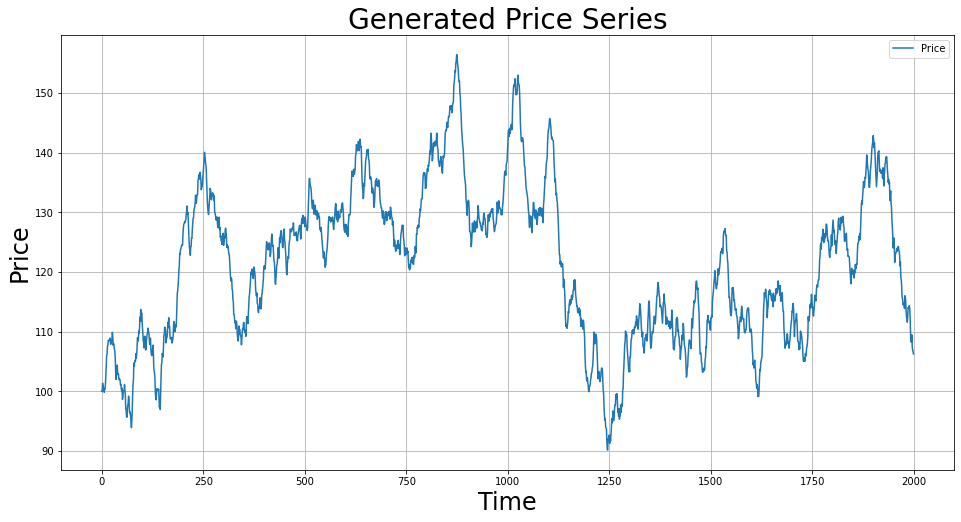

In [73]:
train_price = price[:round(len(price)*0.7)]
test_price = price[round(len(price)*0.7):]
df = pd.DataFrame(price)
df.columns = ["Price"]


plot = df.plot(figsize=(16,8))
plt.title("Generated Price Series", fontsize=28)
plt.ylabel("Price", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.grid()
fig = plot.get_figure()
fig.savefig("Generated Price Series")

# Trading Strategies

In [4]:
C0 = 10000
C = [C0]

## Golden Cross Signal

In [5]:
# moving average signal 

df["50 Day MA"] = df["Price"].rolling(50).mean().dropna()
df["200 Day MA"] = df["Price"].rolling(200).mean().dropna()

#fifty_day = fifty_day.loc[two_hundred_day.index[0]:]

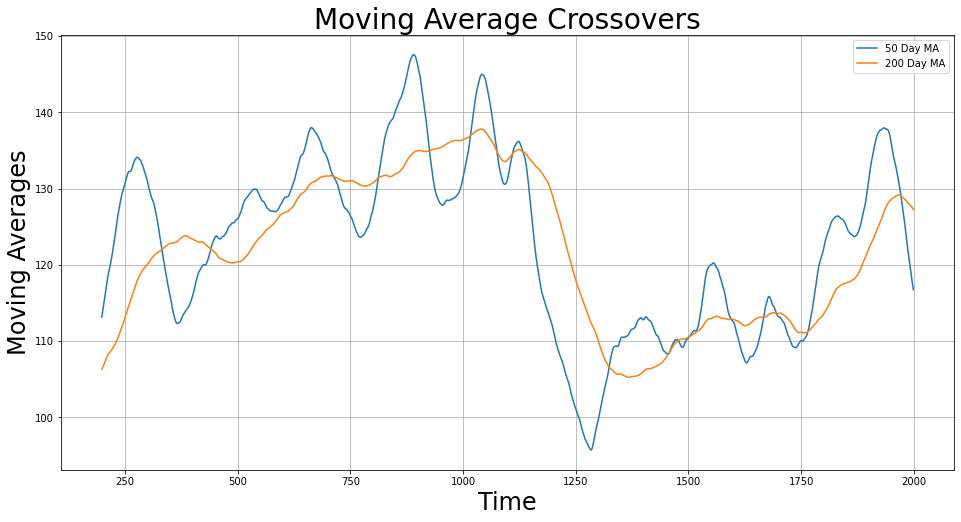

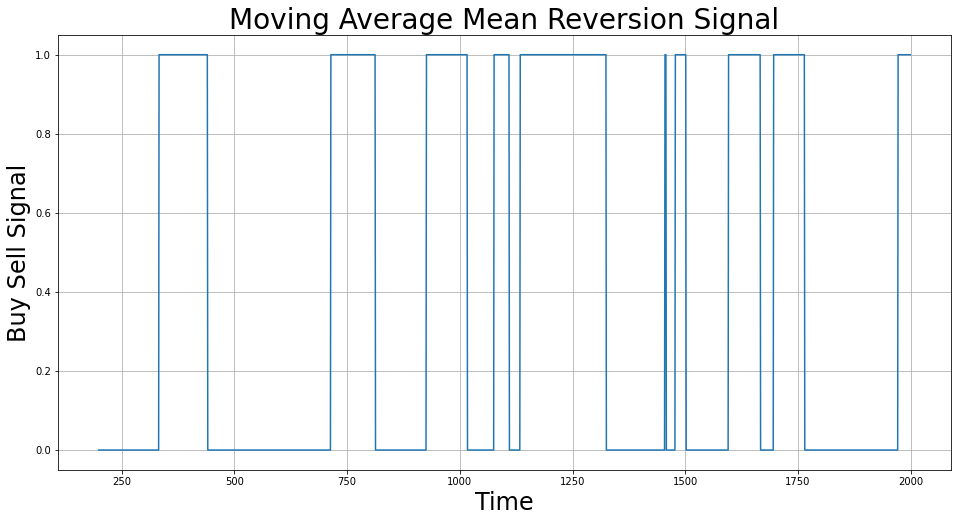

In [71]:
ax = df["50 Day MA"].plot(figsize=(16,8))
df["200 Day MA"].plot(ax=ax)
plt.title("Moving Average Crossovers", fontsize=28)
plt.ylabel("Moving Averages", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.legend()
plt.grid()
fig = ax.get_figure()
fig.savefig("Moving Average Crossovers")
plt.show()

# if 50 day > 200 day -> BUY
# if 50 day < 200 day -> SELL
df = df.dropna()

buy_idx = df[df["50 Day MA"] < df["200 Day MA"]].index

sell_idx = df[df["50 Day MA"] > df["200 Day MA"]].index


# creating buy/sell signal
df["signal"] = 0
df["signal"].loc[buy_idx] = 1
df["signal"].loc[sell_idx] = 0

# plotting signal 
plot = df["signal"].plot(figsize=(16,8))
plt.title("Moving Average Mean Reversion Signal", fontsize=28)
plt.ylabel("Buy Sell Signal", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.grid()
fig = plot.get_figure()
fig.savefig("Moving Average Mean Reversion Signal")
plt.show()

### Using the signal for: 
1) Mean Reversion Strategy 
- Buying when 200 day > 50 day 
- Selling when 200 day < 50 day 
- i.e. anticipating reversion to the mean so when it goes down it should come back up and vice versa

In [7]:
C = [10000]
V = [0]

w = np.zeros(np.shape(df["Price"]))
cash = np.zeros(np.shape(df["Price"]))

cash[0] = 10000

for i, price in enumerate(df["Price"]):
    
    if i == 1800:
        break
    
    if df["signal"].iloc[i] == 1:
        cash_to_invest = cash[i]
        w[i+1] = cash_to_invest/price + w[i]
        cash[i+1] = cash[i] - cash_to_invest
        
        
    elif df["signal"].iloc[i] == 0:
        amount_to_sell = w[i] 
        cash[i+1] = amount_to_sell*price + cash[i]
        w[i+1] = w[i] - amount_to_sell
        
    
        
mean_reversion_strategy = [a*b for a,b in zip(w,df["Price"])] + cash

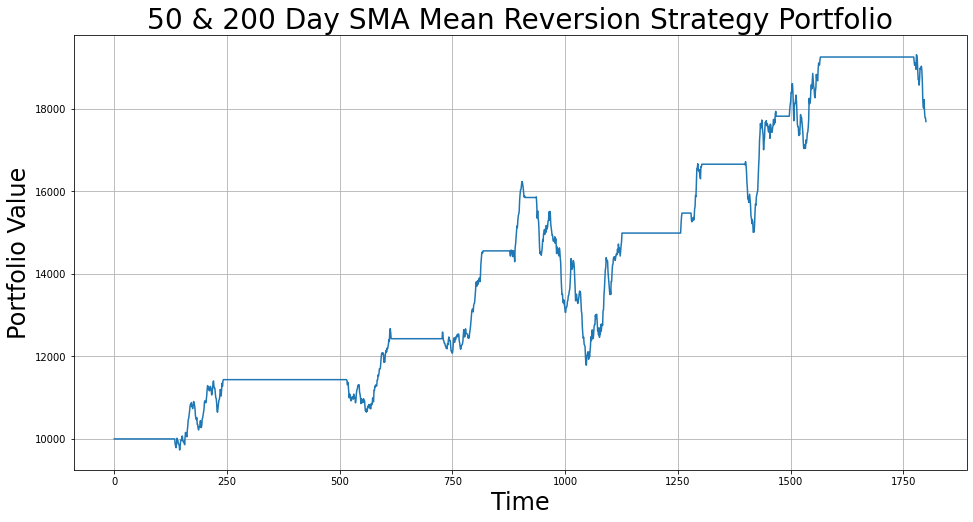

In [72]:
plt.figure(figsize=(16,8))
plt.plot(mean_reversion_strategy)
plt.title("50 & 200 Day SMA Mean Reversion Strategy Portfolio", fontsize=28)
plt.ylabel("Portfolio Value", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.grid()
plt.savefig("50 & 200 Day SMA Mean Reversion Strategy Portfolio")

## AR Trading Strategy
The idea here is to incrementally train an AR model on the returns of the price series and to make trading decisions based off the $\textit{sign}$ of the model's predictions rather than the amplitude or magnitude. 
- If the sign of the prediction is positive, place a buy order with all available cash
- If the sign of the prediction is negative, place a sell order and liquidate all available assets

2) Trend following strategy
- Buying when 200 day < 50 day 
- Selling when 200 day > 50 day 
- i.e. anticipating when it goes high, it goes higher, and when it goes low, it goes lower

In [83]:
from statsmodels.tsa.arima_model import ARIMA as arima
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from scipy.ndimage.interpolation import shift
import warnings
warnings.filterwarnings("ignore")

time_window = 500

y0 = 100
y1 = 100
y = [y0]
y.append(y1)
price = generate_time_series(T, y.copy(), d, phi, theta)
returns = (shift(price, -1) - price)/price
returns = np.delete(returns, -1)
price = np.delete(price, 0)
ar_prediction = np.zeros(np.shape(price))
w = np.zeros(np.shape(price))
cash = np.zeros(np.shape(price))
cash[0] = 10000


signal = []
pred = []

for i, ret in enumerate(returns):
    
    if i == 1997:
        break
        
    ar_prediction[i] = ret
    
    if i >= time_window:
        X = returns[0:i]
        train = X # gradually increases on each loop iteration
        
        # train autoregression
        model = AR(train)
        model_fit = model.fit()
        
        # get prediction: 1 value as a list so 0'th element i.e. only element is taken and stored
        predictions = model_fit.predict(start=len(train), end=len(train), dynamic=False)
        ar_prediction[i] = predictions[0]
        signal.append(np.sign(ar_prediction[i]))
        pred.append(ar_prediction[i])
    
    # if prediction equals value, do nothing
    if ar_prediction[i] == ret:
        w[i+1] = w[i]
        cash[i+1] = cash[i]
        
    # if prediction is greater than value, wealth = prev wealth + ratio of prev cash to curr value
    # i.e. a value in stocks
    elif np.sign(ar_prediction[i]) == 1: 
        w[i+1] = cash[i]/price[i+1]  + w[i]
        cash[i+1] = 0
     
    # if prediction is less than value, cash = prev cash + prev wealth * curr value
    elif np.sign(ar_prediction[i]) == -1:
        cash[i+1] = w[i]*price[i+1] + cash[i]
        w[i+1] = 0
        


# the following retrieves cash position at each point: multiplies wealth (in stock units) by ret
# and then adds cash at each point
ar_strategy = [a*b for a,b in zip(w[:-1], price)] + cash[:-1]

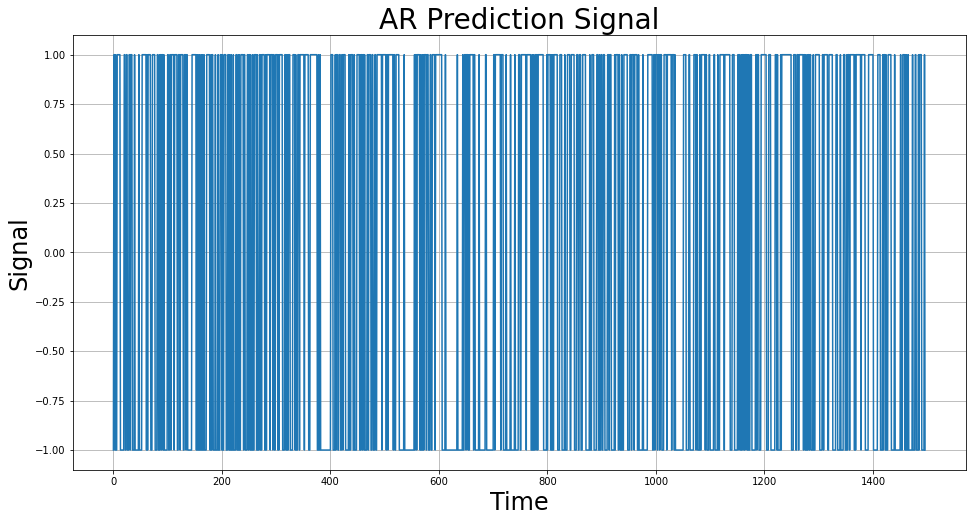

In [82]:
plt.figure(figsize=(16,8))
plt.plot(signal)
plt.title("AR Prediction Signal", fontsize=28)
plt.ylabel("Signal", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.grid()
plt.savefig("AR Prediction Signal")

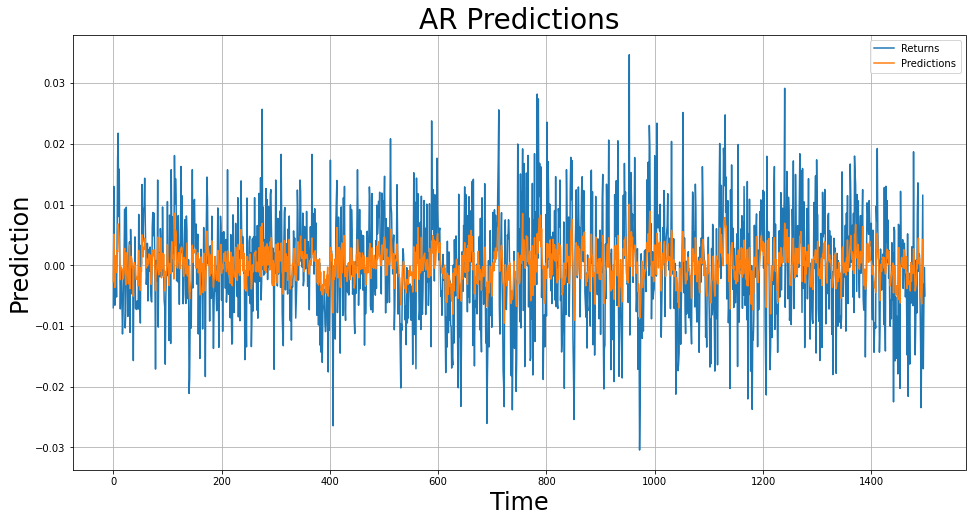

In [88]:
plt.figure(figsize=(16,8))
plt.plot(returns[-1500:], label="Returns")
plt.plot(pred, label="Predictions")

plt.title("AR Predictions", fontsize=28)
plt.ylabel("Prediction", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.grid()
plt.legend()
plt.savefig("AR Predictions")

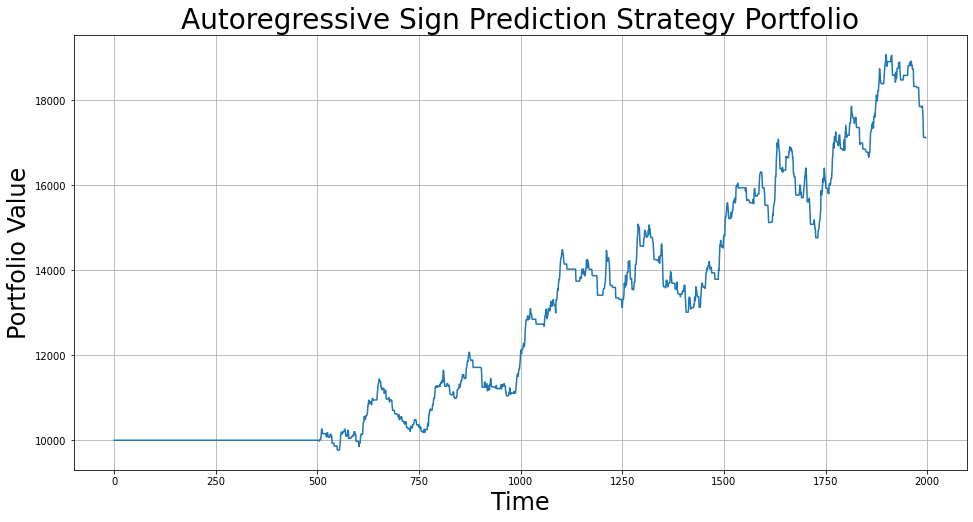

In [74]:
plt.figure(figsize=(16,8))
plt.plot(ar_strategy)
plt.title("Autoregressive Sign Prediction Strategy Portfolio", fontsize=28)
plt.ylabel("Portfolio Value", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.grid()
plt.savefig("Autoregressive Sign Prediction Strategy Portfolio")
plt.show()

### In-Sample AR Prediction

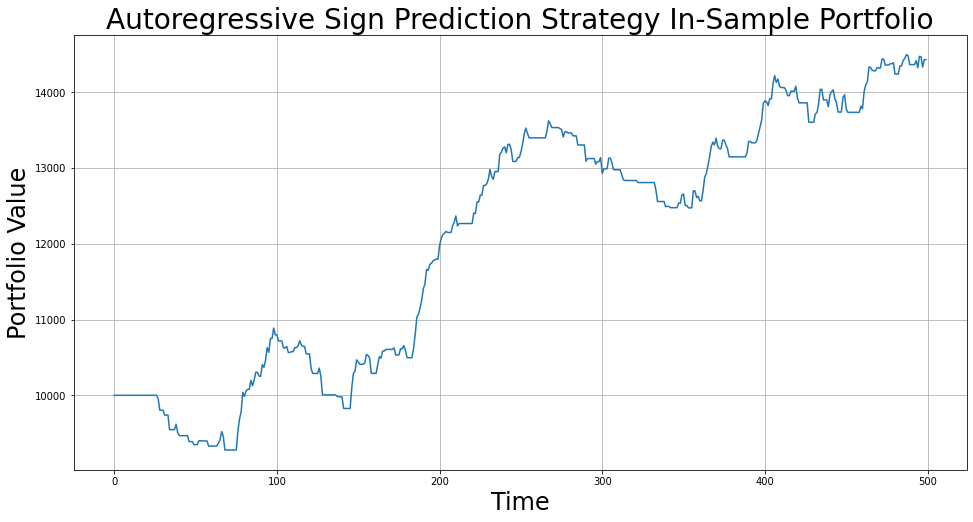

In [75]:
lags = 25 # this value is found by inspecting the number of params the model fit function has 
w = np.zeros(501)
cash = np.zeros(501)
cash[0] = 10000

X = returns[0:500]
train = X
model = AR(train)
model_fit = model.fit()

# the model is not fit in this code - it is only trained on the first 500 values
for i, ret in enumerate(returns):
    
    if i == 500:
        break
        
    ar_prediction[i] = ret
    
    if i >= lags:
        X = returns[0:i]
        train = X # gradually increases on each loop iteration
        
        # train autoregression
        #model = AR(train)
        #model_fit = model.fit()
        
        # get prediction: 1 value as a list so 0'th element i.e. only element is taken and stored
        predictions = model_fit.predict(start=len(train), end=len(train), dynamic=False)
        ar_prediction[i] = predictions[0]
    
    # if prediction equals value, do nothing
    if ar_prediction[i] == ret:
        w[i+1] = w[i]
        cash[i+1] = cash[i]
        
    # if prediction is greater than value, wealth = prev wealth + ratio of prev cash to curr value
    # i.e. a value in stocks
    elif np.sign(ar_prediction[i]) == 1: 
        w[i+1] = cash[i]/price[i+1]  + w[i]
        cash[i+1] = 0
     
    # if prediction is less than value, cash = prev cash + prev wealth * curr value
    elif np.sign(ar_prediction[i]) == -1:
        cash[i+1] = w[i]*price[i+1] + cash[i]
        w[i+1] = 0
        


# the following retrieves cash position at each point: multiplies wealth (in stock units) by ret
# and then adds cash at each point
ar_strategy_train = [a*b for a,b in zip(w[:-1], price)] + cash[:-1]

# plotting
plt.figure(figsize=(16,8))
plt.plot(ar_strategy_train)
plt.grid()
plt.title("Autoregressive Sign Prediction Strategy In-Sample Portfolio", fontsize=28)
plt.ylabel("Portfolio Value", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.savefig("Autoregressive Sign Prediction Strategy In-Sample Portfolio")
plt.show()

## LSTM Trading Strategy

In [102]:
price = generate_time_series(T, y.copy(), d, phi, theta)
returns = (shift(price, -1) - price)/price
returns = np.delete(returns, -1)

In [103]:
train_returns = returns[:round(0.7*len(returns))]
test_returns = returns[round(0.7*len(returns)):]

### Creating Train Data 

In [104]:
num_days = 20
X_train = []
y_train = []

for i in range(num_days, len(train_returns)-1):
    X = train_returns[i-num_days:i]
    y = train_returns[i:i+1]
    
    X_train.append(X)
    y_train.append(y)
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

### Scaling Train Data

In [105]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train_scaled = []
y_train_scaled = []


for i in range(0, len(X_train)):
    
    scaler = MinMaxScaler()
    
    X = scaler.fit_transform(X_train[i])
    y = scaler.transform(y_train[i].reshape(1, -1))
    
    X_train_scaled.append(X)
    y_train_scaled.append(y)

X_train_scaled, y_train_scaled = np.array(X_train_scaled), np.array(y_train_scaled)    
y_train_scaled = y_train_scaled.reshape(y_train_scaled.shape[0]) 

In [106]:
X_train.shape[1]

20

### Initialising and Training Model

In [108]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (num_days, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# training model
model.fit(X_train_scaled, y_train_scaled, epochs = 100, batch_size = 64, verbose=1)

Epoch 1/100
22/22 [==============================] - 4s 24ms/step - loss: 0.1591
Epoch 2/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0951
Epoch 3/100
22/22 [==============================] - 0s 22ms/step - loss: 0.1016
Epoch 4/100
22/22 [==============================] - 0s 22ms/step - loss: 0.1004
Epoch 5/100
22/22 [==============================] - 0s 22ms/step - loss: 0.1003
Epoch 6/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0950
Epoch 7/100
22/22 [==============================] - 0s 22ms/step - loss: 0.1014
Epoch 8/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0918
Epoch 9/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0978: 0s - loss: 0.0
Epoch 10/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0961
Epoch 11/100
22/22 [==============================] - 1s 25ms/step - loss: 0.1013
Epoch 12/100
22/22 [==============================] - 1s 24ms/step - loss: 0.1050
Epoch 13/

22/22 [==============================] - 0s 23ms/step - loss: 0.0849


In [123]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

### Plotting Train Predictions vs Actual

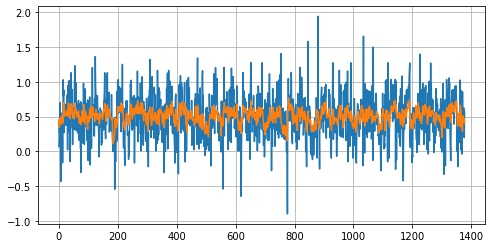

In [111]:
train_pred = model.predict(X_train_scaled)

plt.figure(figsize=(8,4))
plt.plot(y_train_scaled)
plt.plot(train_pred)
plt.grid()

### Descaling Train Predictions

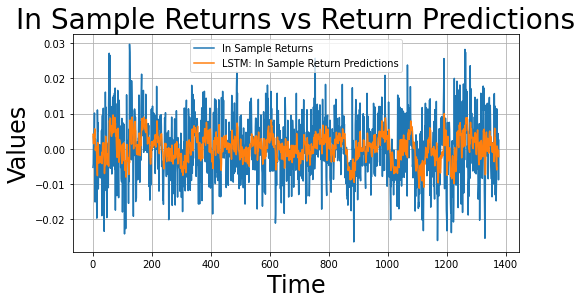

In [114]:
descaled_train = []
train_pred = model.predict(X_train_scaled)

for i in range(0, len(X_train)):
    
    scaler = MinMaxScaler()
    
    X = scaler.fit_transform(X_train[i].reshape(-1, 1))
    
    y = scaler.inverse_transform(train_pred[i].reshape(1, -1))
    
    descaled_train.append(y)
    
descaled_train = np.array(descaled_train)
descaled_train = descaled_train.reshape(-1)

plt.figure(figsize=(8,4))
plt.plot(y_train, label="In Sample Returns")
plt.plot(descaled_train, label="LSTM: In Sample Return Predictions")
plt.title("In Sample Returns vs Return Predictions", fontsize=28)
plt.ylabel("Values", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.grid()
plt.legend()
plt.savefig("In Sample Returns vs Return Predictions")

### Creating Test Data

In [21]:
X_test = []
y_test = []

for i in range(num_days, len(test_returns)):
    X = test_returns[i-num_days:i]
    y = test_returns[i:i+1]
    
    X_test.append(X)
    y_test.append(y)

### Scale Test Data

In [22]:
X_test_scaled = []
y_test_scaled = []

for i in range(0, len(X_test)):
    
    scaler = MinMaxScaler()
    
    X = scaler.fit_transform(X_test[i].reshape(-1, 1))
    y = scaler.transform(y_test[i].reshape(1, -1))
    
    X_test_scaled.append(X)
    y_test_scaled.append(y)
    
X_test_scaled, y_test_scaled = np.array(X_test_scaled), np.array(y_test_scaled)    
y_test_scaled = y_test_scaled.reshape(y_test_scaled.shape[0])     

### Making Test Predictions

In [23]:
prediction = model.predict(X_test_scaled)

### Plotting Prediction against Actual

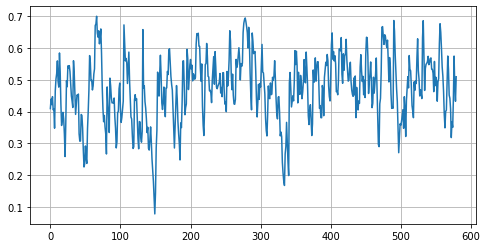

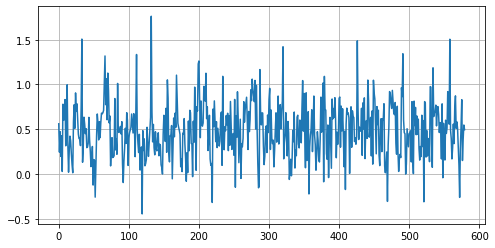

In [24]:
plt.figure(figsize=(8,4))
plt.plot(prediction)
plt.grid()

plt.figure(figsize=(8,4))
plt.plot(y_test_scaled)
plt.grid()

### De-Scaling Predictions and Plotting Descaled Predictions vs Actual

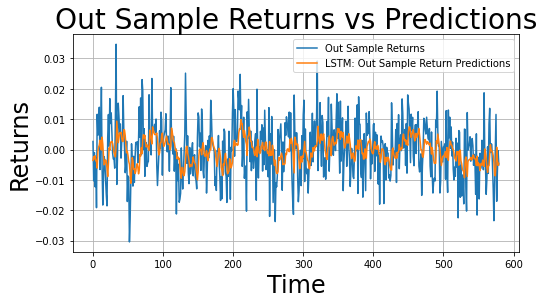

In [124]:
descaled_pred = []

for i in range(0, len(X_test)):
    
    scaler = MinMaxScaler()
    
    X = scaler.fit_transform(X_test[i].reshape(-1, 1))
    
    y = scaler.inverse_transform(prediction[i].reshape(1, -1))
    
    descaled_pred.append(y)
    
descaled_pred = np.array(descaled_pred)

descaled_pred = descaled_pred.reshape(-1)

plt.figure(figsize=(8,4))
plt.plot(y_test, label="Out Sample Returns")
plt.plot(descaled_pred, label="LSTM: Out Sample Return Predictions")
plt.grid()
plt.title("Out Sample Returns vs Predictions", fontsize=28)
plt.ylabel("Returns", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.legend()
plt.savefig("Out Sample Returns vs Predictions")

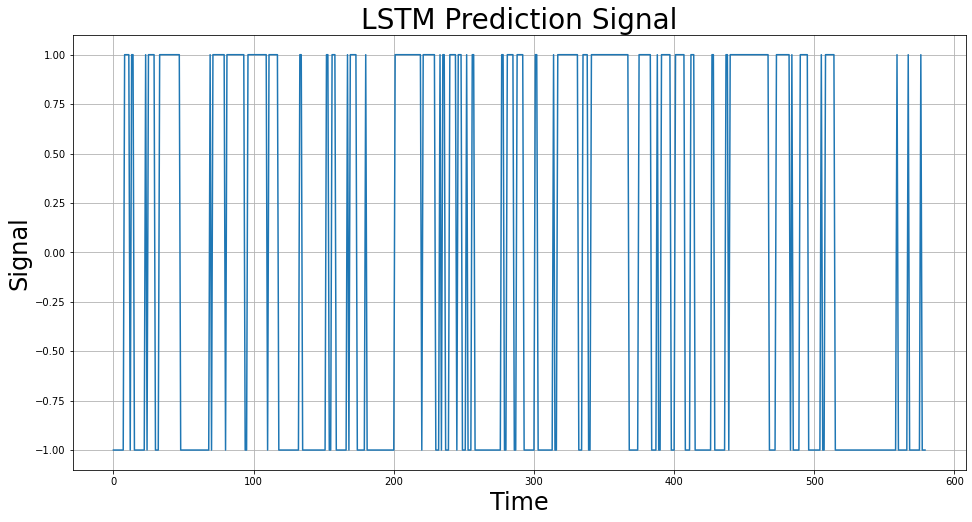

In [122]:
plt.figure(figsize=(16,8))
plt.plot(np.sign(descaled_pred))
plt.title("LSTM Prediction Signal", fontsize=28)
plt.ylabel("Signal", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.grid()
plt.savefig("LSTM Prediction Signal")

### Inspecting Correlations of Prediction with Desired Output
- Correlation of signs
- Correlation of raw

In [27]:
display(np.corrcoef(np.sign(descaled_pred), np.sign(y_test_scaled)))
display(np.corrcoef(descaled_pred, y_test_scaled))

array([[1.        , 0.06201666],
       [0.06201666, 1.        ]])

array([[ 1.        , -0.04387385],
       [-0.04387385,  1.        ]])

### Implementing LSTM Trading Strategy - Train

In [30]:
w = np.zeros(1379)
cash = np.zeros(1379)
cash[0] = 10000


for i, ret in enumerate(train_returns):
    
    if i == 1378:
        break
        
    if np.sign(descaled_train[i]) == 1:
            w[i+1] = cash[i]/price[i+1]  + w[i]
            cash[i+1] = 0
            
    elif np.sign(descaled_train[i]) == -1:
        cash[i+1] = w[i]*price[i+1] + cash[i]
        w[i+1] = 0
        
lstm_strategy_train = [a*b for a,b in zip(w, price[:1420])] + cash

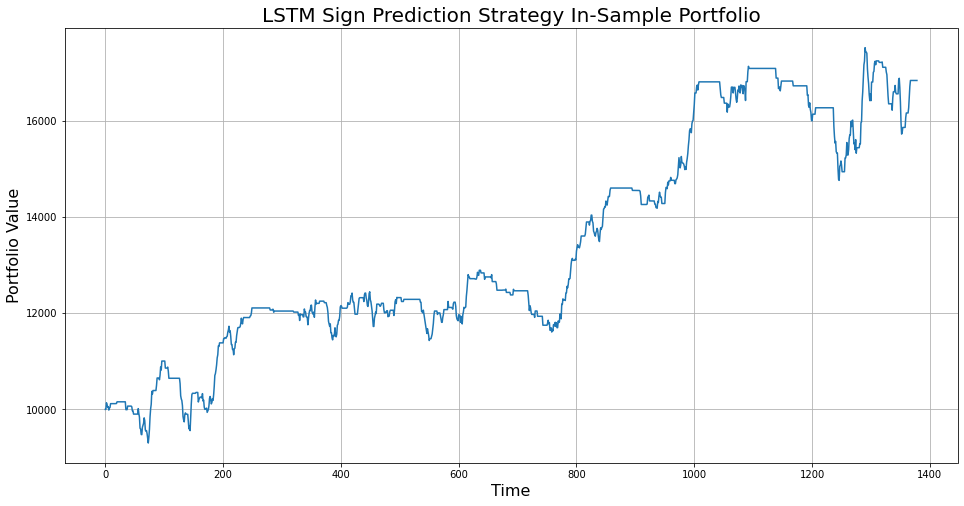

In [147]:
plt.figure(figsize=(16,8))
plt.plot(lstm_strategy_train)
plt.grid()
plt.title("LSTM Sign Prediction Strategy In-Sample Portfolio", fontsize=20)
plt.ylabel("Portfolio Value", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.savefig("LSTM Sign Prediction Strategy In-Sample Portfolio")

### Implementing LSTM Trading Strategy - Test

In [32]:
time_window = len(train_returns)

w = np.zeros(580)
cash = np.zeros(580)
cash[0] = 10000

for i, ret in enumerate(test_returns):
    
    if i == 579:
        break
        
    if np.sign(descaled_pred[i]) == 1:
            w[i+1] = cash[i]/price[i+1]  + w[i]
            cash[i+1] = 0
            
    elif np.sign(descaled_pred[i]) == -1:
        cash[i+1] = w[i]*price[i+1] + cash[i]
        w[i+1] = 0
        
lstm_strategy = [a*b for a,b in zip(w, price[1420:])] + cash

### Plotting Trading Strategy Alongside Price

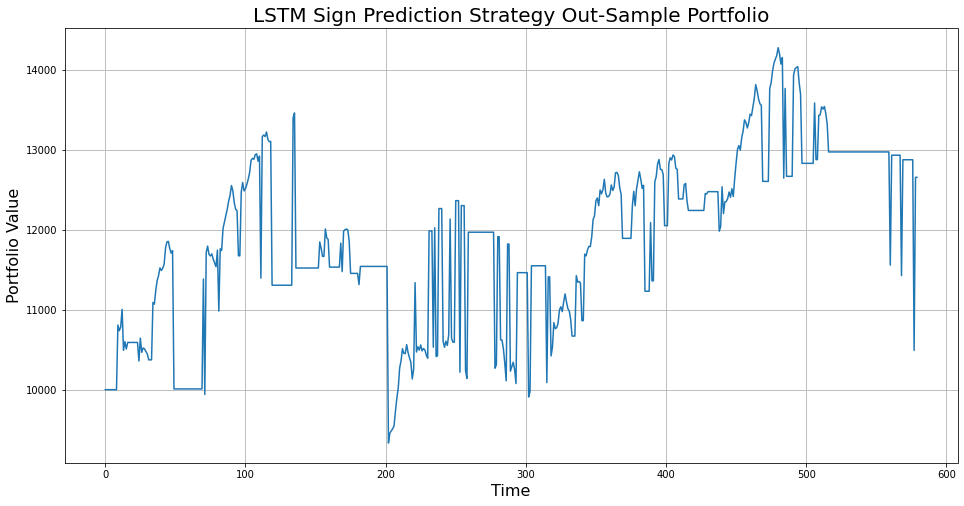

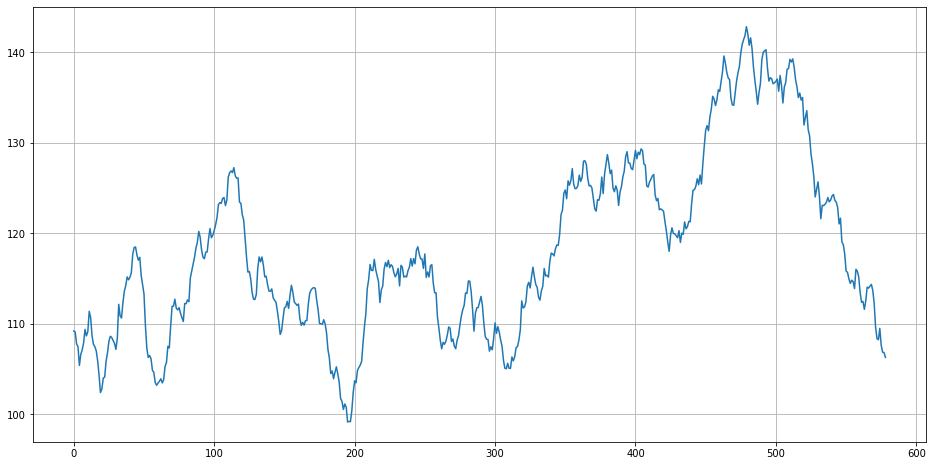

In [47]:
plt.figure(figsize=(16,8))
plt.plot(lstm_strategy)
plt.grid()
plt.title("LSTM Sign Prediction Strategy Out-Sample Portfolio", fontsize=20)
plt.ylabel("Portfolio Value", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.savefig("LSTM Sign Prediction Strategy Out-Sample Portfolio")

plt.figure(figsize=(16,8))
plt.plot(price[1421:])
plt.grid()

## Performance Indicators

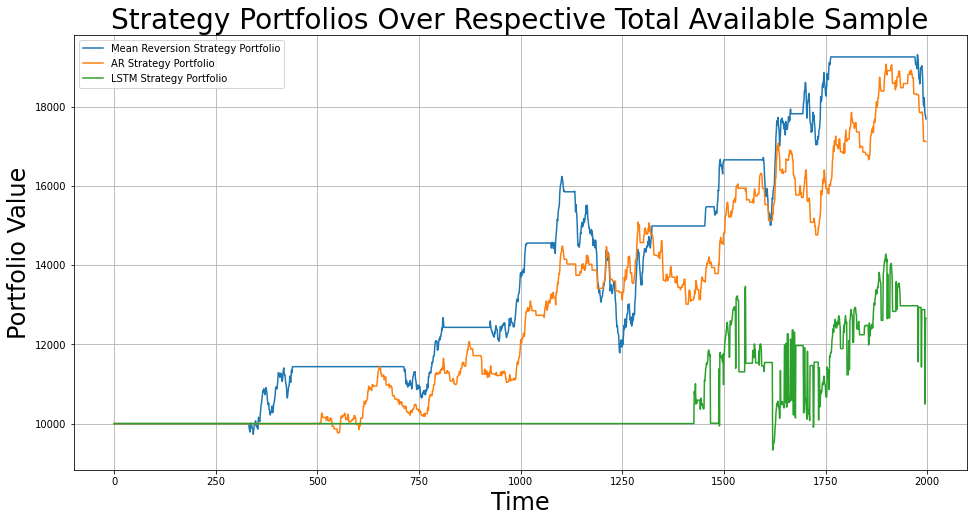

In [125]:
zeros = np.zeros(197) + C[0]
mean_reverting_strat = np.concatenate((zeros, mean_reversion_strategy))

zeros = np.zeros(len(ar_strategy) - len(lstm_strategy)) + C[0]
LSTM_strat = np.concatenate((zeros, lstm_strategy))

plt.figure(figsize=(16,8))
plt.plot(mean_reverting_strat, label="Mean Reversion Strategy Portfolio")
plt.plot(ar_strategy, label="AR Strategy Portfolio")
plt.plot(LSTM_strat, label="LSTM Strategy Portfolio")
plt.title("Strategy Portfolios Over Respective Total Available Sample", fontsize=28)
plt.ylabel("Portfolio Value", fontsize=24)
plt.xlabel("Time", fontsize=24)
plt.legend()
plt.grid()
plt.savefig("Strategy Total Sample Portfolios")



### Returns of Each Strategy

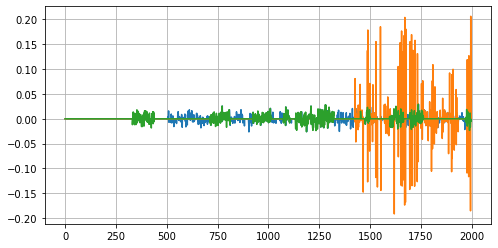

In [50]:
# fully extended return price series
plt.figure(figsize=(8,4))

ar_returns = (shift(ar_strategy, -1) - ar_strategy)/ar_strategy
ar_returns = np.delete(ar_returns, -1)
plt.plot(ar_returns)


lstm_returns = (shift(LSTM_strat, -1) - LSTM_strat)/LSTM_strat
lstm_returns = np.delete(lstm_returns, -1)
plt.plot(lstm_returns)


mv_returns = (shift(mean_reverting_strat, -1) - mean_reverting_strat)/mean_reverting_strat
mv_returns = np.delete(mv_returns, -1)
plt.plot(mv_returns)

plt.grid()

### Last 600 days performance of each strat

Sharpe Ratios:


0.795

0.939

0.149

Sortino Ratios:


0.804

1.167

0.126

Calmar Ratios:


0.016

0.047

0.021

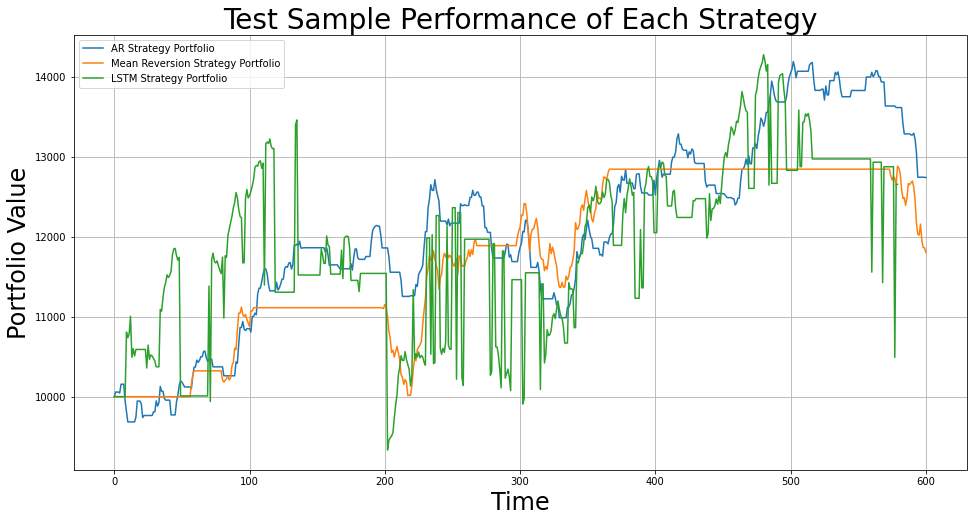

In [167]:
# AR

r = ar_returns[-600:]
c = [10000]
for i, ret in enumerate(r):
    c.append(c[i]*(1+ret))
    


r = mv_returns[-600:]
c_mv = [10000]
for i, ret in enumerate(r):
    c_mv.append(c_mv[i]*(1+ret))
    

plt.figure(figsize=(16,8))
plt.plot(c, label="AR Strategy Portfolio")
plt.plot(c_mv, label="Mean Reversion Strategy Portfolio")
plt.plot(lstm_strategy, label="LSTM Strategy Portfolio")
plt.legend()
plt.grid()
plt.title("Test Sample Performance of Each Strategy", fontsize=28)
plt.ylabel("Portfolio Value", fontsize=24)
plt.xlabel("Time", fontsize=24)
#plt.savefig("Test Sample Performance of Each Strategy")



mv_sharpe = sharpe(log_returns(c_mv))
ar_sharpe = sharpe(log_returns(c))
lstm_sharpe = sharpe(log_returns(lstm_strategy))

mv_sortino = sortino(log_returns(c_mv))
ar_sortino = sortino(log_returns(c))
lstm_sortino = sortino(log_returns(lstm_strategy))

mv_calmar = calmar(log_returns(c_mv), mean_reverting_strat)
ar_calmar = calmar(log_returns(c), ar_strategy)
lstm_calmar = calmar(log_returns(lstm_strategy), lstm_strategy)

print("Sharpe Ratios:")
display(mv_sharpe, ar_sharpe, lstm_sharpe)

print("Sortino Ratios:")
display(mv_sortino, ar_sortino, lstm_sortino)

print("Calmar Ratios:")
display(mv_calmar, ar_calmar, lstm_calmar)

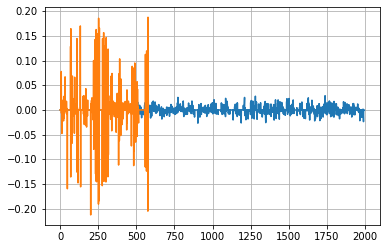

In [139]:
## modify to LOG RETURNS
def price_returns(strat):
    returns = (shift(strat, -1) - strat)/strat
    returns = np.delete(returns, -1)
    return returns


def log_returns(strat):
    returns = np.log(shift(strat, -1)/strat)
    returns = np.delete(returns, -1)
    return returns


mv_log_returns = log_returns(mean_reversion_strategy)
ar_log_returns = log_returns(ar_strategy)
lstm_log_returns = log_returns(lstm_strategy)


plt.figure()
plt.plot(ar_log_returns)
plt.plot(lstm_log_returns)
#plt.plot(mv_log_returns)
plt.grid()

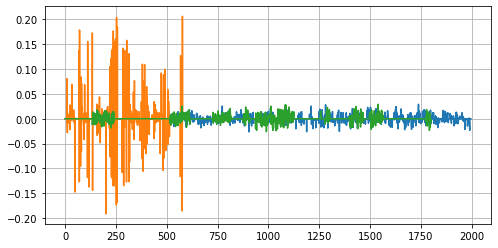

In [84]:
# returns of trading sections of each

mv_returns = (shift(mean_reversion_strategy, -1) - mean_reversion_strategy)/mean_reversion_strategy
mv_returns = np.delete(mv_returns, -1)

ar_returns = (shift(ar_strategy, -1) - ar_strategy)/ar_strategy
ar_returns = np.delete(ar_returns, -1)

lstm_returns = (shift(lstm_strategy, -1) - lstm_strategy)/lstm_strategy
lstm_returns = np.delete(lstm_returns, -1)

plt.figure(figsize=(8,4))
plt.plot(ar_returns)
plt.plot(lstm_returns)
plt.plot(mv_returns)
plt.grid()

### Standard Deviations of Each Strategy

In [85]:
mv_std = np.std(mv_returns)
ar_std = np.std(ar_returns)
lstm_std = np.std(lstm_returns)

display(mv_std, ar_std, lstm_std)

0.0058143504657124185

0.005554786633945487

0.0436608743228697

### Sharpe Ratios

In [160]:
def sharpe(returns):
    sharpe_ratio = np.mean(returns)/np.std(returns)
    return np.round(sharpe_ratio * np.sqrt(252), 3)

mv_sharpe = sharpe(mv_log_returns)
ar_sharpe = sharpe(ar_log_returns)
lstm_sharpe = sharpe(lstm_log_returns)

print("Sharpe Ratios:")
display(mv_sharpe, ar_sharpe, lstm_sharpe)

Sharpe Ratios:


0.866

0.77

0.149

### Sortino Ratio

In [161]:
def sortino(returns):
    downside_returns = [ret for ret in returns if ret < 0]
    std = np.std(downside_returns)
    sortino = np.mean(returns)/std
    return np.round(sortino * np.sqrt(252), 3)

mv_sortino = sortino(mv_log_returns)
ar_sortino = sortino(ar_log_returns)
lstm_sortino = sortino(lstm_log_returns)

print("Sortino Ratios:")
display(mv_sortino, ar_sortino, lstm_sortino)

Sortino Ratios:


0.911

0.886

0.126

### Calmar Ratio
- Expected Return / Max Drawdown

In [162]:
def max_dd(data):
    i = np.argmax(np.maximum.accumulate(data) - data)
    j = np.argmax(data[:i])
    max_drawdown = (data[i]-data[j])/data[j]
    return np.round(abs(max_drawdown), 3)

In [164]:
def calmar(returns, strat):
    drawdown = max_dd(strat)
    calmar = np.sqrt(252) * np.mean(returns)/drawdown
    return np.round(calmar, 3) 

mv_calmar = calmar(mv_log_returns, mean_reverting_strat)
ar_calmar = calmar(ar_log_returns, ar_strategy)
lstm_calmar = calmar(lstm_log_returns, lstm_strategy)
print("Calmar Ratios:")
display(mv_calmar, ar_calmar, lstm_calmar)

Calmar Ratios:


0.018

0.031

0.021

### In-Sample Ratios for AR and LSTM Strategies

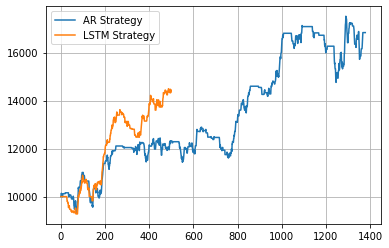

In [155]:
plt.plot(lstm_strategy_train, label="AR Strategy")
plt.plot(ar_strategy_train, label="LSTM Strategy")
plt.legend()
plt.grid()

In [156]:
ar_train_sharpe = sharpe(log_returns(ar_strategy_train))
lstm_train_sharpe = sharpe(log_returns(lstm_strategy_train))

print("In-sample sharpe ratios for AR and LSTM strategies:", ar_train_sharpe, lstm_train_sharpe)

In-sample sharpe ratios for AR and LSTM strategies: 1.8679009102021504 0.9716572203114587


### T-Test P Value for Out-sample Sharpe, Sortino, and Calmar Ratios and Bonferroni Adjustment

In [209]:
print(p_val(c), p_val(c_mv), p_val(lstm_strategy))

p_vals = [p_val(mean_reverting_strat), p_val(ar_strategy), p_val(lstm_strategy)]

print(p_vals)

0.17443329907542932 0.2136908271054424 0.44079189705833194
[0.2058151562130428, 0.22092700441870106, 0.44079189705833194]


In [200]:
def p_val(c):
    t_ratio = np.mean(log_returns(c))/np.std(log_returns(c)) * np.sqrt(252)
    return t.sf(t_ratio, 252-1)

print(p_val(c), p_val(c_mv), p_val(lstm_strategy))

p_vals = [p_val(c), p_val(c_mv), p_val(lstm_strategy)]

# adjusted

ad_pvals = [3*x for x in p_vals]

ad_pvals

0.17443329907542932 0.2136908271054424 0.44079189705833194


[0.5232998972262879, 0.6410724813163272, 1.3223756911749958]

In [208]:
t.sf(2.14, 252-1)

0.016659572091981947

### Multiple Testing Sharpe Ratio Adjustment
This adjustment reflects the likelihood of finding a strategy that is at least as profitable as
the observed strategy after searching through N individual strategies.

In [923]:
N = 10
p_M_sharpe =  1 - (1 - p_sharpe)**3
print("Multiple Sharpe Ratio adjustment:", p_M_sharpe)

N = 10
p_M_sortino =  1 - (1 - p_sortino)**3
print("Multiple Sortino Ratio adjustment:", p_M_sortino)

N = 10
p_M_calmar =  1 - (1 - p_calmar)**3
print("Multiple Calmar Ratio adjustment:", p_M_calmar)

Multiple Sharpe Ratio adjustment: 0.01358360224207178
Multiple Sortino Ratio adjustment: 0.028471249224518824
Multiple Calmar Ratio adjustment: 0.08001352927748118
